<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/%EB%AF%B8%EB%8B%88_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 병원 개/폐업 분류 예측 경진대회
- 과제 : 데이콘의 '병원 개/폐업 분류 예측 경진대회' 데이터셋을 전처리 및 시각화하고, 분류 알고리즘을 적용한다.

- 조건 : 분류 모델 3가지 이상 적용

- Class label 명은 OC이다. 

### | 데이터 전처리
-------

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load data
test = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/test.csv")
train = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/train.csv")
sub = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/submission_sample.csv")

In [ ]:
train.shape

(301, 58)

In [ ]:
train.head(3)

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,...,758993742.0,222876855.0,0.0,536116887.0,390000000.0,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,234.0,1.0,same


- 클래스 값 'OC' 를 포함한 Feature가 58개 존재한다.
- 컬럼명 마지막에 1이 붙으면 2017년, 2가 붙으면 2016년 데이터이다. 

In [ ]:
# feature의 타입과 Null 값 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [ ]:
# nan값 하나라도 있는 행 출력
train[train.isna().any(axis=1)]

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
14,26,open,ulsan,127,20160531,237.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,951.0,901.0,same
32,55,open,incheon,141,19930708,232.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323.0,323.0,same
35,58,close,gyeonggi,168,20130206,132.0,nursing_hospital,2.681766e+09,1.802009e+08,2.014580e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,51.0,NaN,change
48,74,open,seoul,1,19940425,28.0,traditional_hospital,8.872427e+09,9.641249e+08,7.638920e+09,...,5.958278e+09,5.956278e+09,4.992758e+09,2.000000e+06,0.000000e+00,3.625952e+09,0.000000e+00,NaN,NaN,NaN
55,87,open,gyeonggi,120,20130314,327.0,nursing_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,203.0,same
60,94,open,gangwon,128,20031201,244.0,nursing_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,96,open,busan,64,20170602,128.0,nursing_hospital,5.236406e+08,2.306773e+07,8.355775e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,38.0,NaN,NaN
71,107,close,jeonbuk,26,19990805,NaN,traditional_hospital,4.131858e+09,1.436118e+08,3.529097e+09,...,2.658296e+09,2.632717e+09,2.442951e+09,2.557878e+07,0.000000e+00,2.487828e+09,0.000000e+00,85.0,74.0,same
93,140,close,gyeongbuk,114,20070420,203.0,hospital,5.423357e+09,0.000000e+00,5.212041e+09,...,2.733619e+09,1.406195e+08,0.000000e+00,2.590000e+09,2.590000e+09,3.752184e+09,0.000000e+00,NaN,NaN,NaN


In [ ]:
# 각 feature의 값 분포 확인
train.describe()

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
count,301.000000,301.000000,3.010000e+02,296.000000,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,...,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,291.000000,288.000000
mean,219.056478,81.039867,2.005013e+07,145.709459,1.288175e+10,2.014903e+09,1.033244e+10,5.654115e+09,2.696151e+08,5.115870e+08,...,2.226700e+05,8.146026e+09,3.860584e+09,1.510050e+09,4.471247e+09,2.709979e+09,5.273919e+09,9.786279e+08,142.546392,134.326389
std,121.234869,50.969714,8.893815e+04,118.923890,2.043543e+10,7.460271e+09,1.493886e+10,8.083343e+09,8.023701e+08,1.060379e+09,...,3.811496e+06,1.255800e+10,6.797242e+09,2.953412e+09,7.659580e+09,4.564001e+09,1.081259e+10,4.688798e+09,160.191073,151.061786
min,1.000000,1.000000,1.978012e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.014780e+10,-2.781507e+09,0.000000,0.000000
25%,112.000000,37.000000,2.001102e+07,52.750000,3.252112e+09,0.000000e+00,2.758201e+09,1.626053e+09,8.217133e+06,8.013395e+07,...,0.000000e+00,1.283220e+09,2.855741e+08,0.000000e+00,2.557878e+07,0.000000e+00,1.017573e+09,0.000000e+00,53.500000,53.750000
50%,230.000000,75.000000,2.007113e+07,136.500000,5.524218e+09,2.104105e+08,4.684074e+09,2.659892e+09,4.363764e+07,1.831965e+08,...,0.000000e+00,3.784553e+09,1.454050e+09,8.542549e+07,1.969747e+09,1.100000e+09,2.894970e+09,0.000000e+00,80.000000,79.000000
75%,321.000000,123.000000,2.011102e+07,193.000000,1.274839e+10,9.105278e+08,1.077876e+10,6.363400e+09,2.050331e+08,4.203330e+08,...,0.000000e+00,8.465053e+09,4.364714e+09,1.567967e+09,4.905441e+09,3.360000e+09,5.370285e+09,1.014447e+08,181.500000,170.000000
max,428.000000,178.000000,2.017061e+07,656.000000,1.510000e+11,9.850332e+10,1.030000e+11,6.403559e+10,9.144171e+09,8.686380e+09,...,6.524231e+07,8.508858e+10,6.846878e+10,1.759375e+10,5.150388e+10,3.256147e+10,1.250000e+11,6.852730e+10,1200.000000,1200.000000


### OC : 병원 개/폐업 여부

In [ ]:
# 전체 데이터의 개/폐업 비율
train['OC'].value_counts()

open      286
 close     15
Name: OC, dtype: int64

Text(0.5, 1.0, 'Train[OC]')

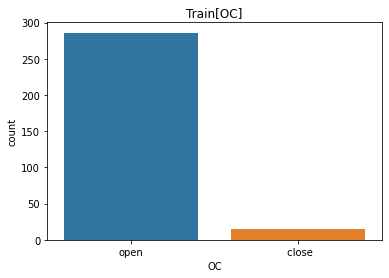

In [ ]:
sns.countplot(x='OC', data=train).set_title('Train[OC]')

- 'close' 데이터 적음, 데이터 불균형
- 오버샘플링 고려

In [ ]:
# open->1, close->0 으로 변경
train['OC'].replace({'open':1, ' close':0}, inplace=True)

### sido: 병원의 광역 지역 정보


In [ ]:
# 'sido' 결측치 개수 확인
train['sido'].isnull().sum(), test['sido'].isnull().sum()

(0, 0)

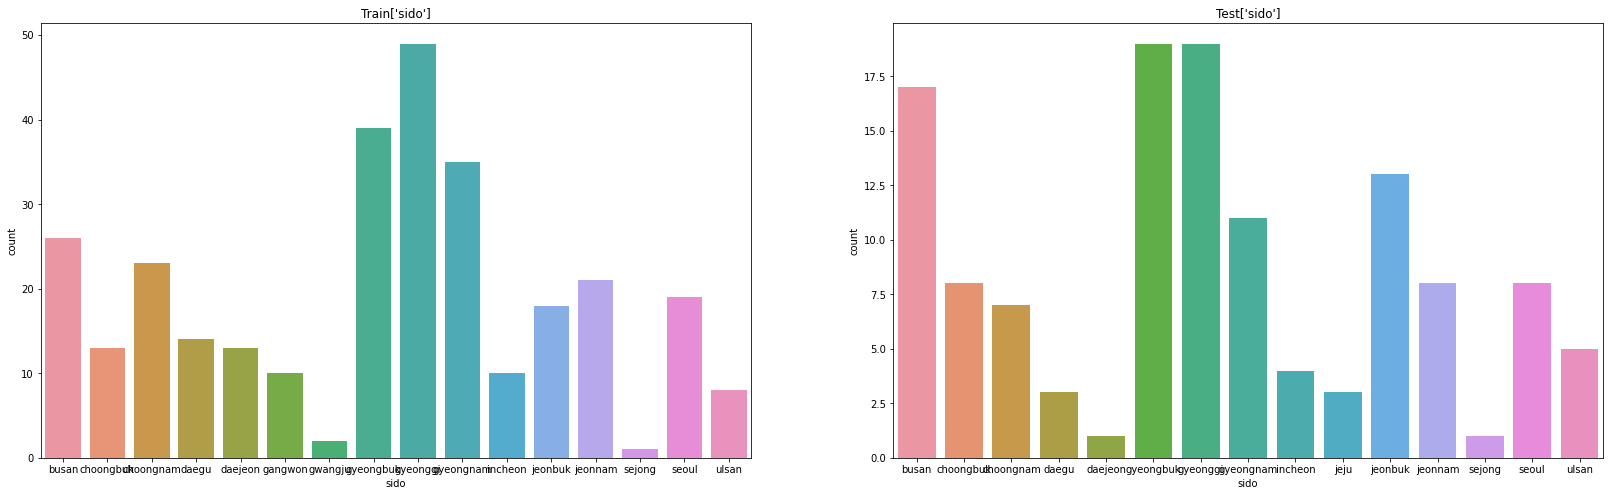

In [ ]:
# sido distribution in alphabetical order
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.countplot(data=train.sort_values(by="sido"), x="sido", ax=ax[0]).set_title("Train['sido']")
sns.countplot(data=test.sort_values(by="sido"), x="sido", ax=ax[1]).set_title("Test['sido']")
plt.show()

In [ ]:
print("train에만 존재")
print(set(train["sido"].value_counts().index) - set(test["sido"].value_counts().index))
print("\ntest에만 존재")
print(set(test["sido"].value_counts().index) - set(train["sido"].value_counts().index))

train에만 존재
{'gwangju', 'gangwon'}

test에만 존재
{'jeju'}


In [ ]:
display(train['sido'].value_counts().loc[['gwangju', 'gangwon']])
display(test['sido'].value_counts().loc[['jeju']])

gwangju     2
gangwon    10
Name: sido, dtype: int64

jeju    3
Name: sido, dtype: int64

- train, test 광역 지역 분포 유사
- train, test에만 있는 광역 지역 있음

In [ ]:
train.groupby('sido')['OC'].value_counts()

sido       OC
busan      1     25
           0      1
choongbuk  1     13
choongnam  1     22
           0      1
daegu      1     14
daejeon    1     13
gangwon    1     10
gwangju    1      2
gyeongbuk  1     37
           0      2
gyeonggi   1     44
           0      5
gyeongnam  1     35
incheon    1     10
jeonbuk    1     16
           0      2
jeonnam    1     18
           0      3
sejong     1      1
seoul      1     18
           0      1
ulsan      1      8
Name: OC, dtype: int64

- train에만 있는 gwangju, gangwon의 경우 폐원한 병원 데이터가 없고
- test에만 있는 jeju의 경우 병원이 3개뿐임으로 크게 문제 없어보임

In [486]:
# ~남 ~북을 각각 충청, 전라, 경상으로 통합
# 인천&경기 -> 경인, 광주 -> 전라, 대전&새종 -> 충청, 울산&대구 -> 경상
train['sido'] = train['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})
test['sido'] = test['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})

- 남과 북을 합쳐 도 개수를 줄여본다.
- 인천, 경기를 경인으로
- 광주를 전라로
- 대전, 세종을 충청으로
- 울산, 대구를 경상으로 통합한다. 

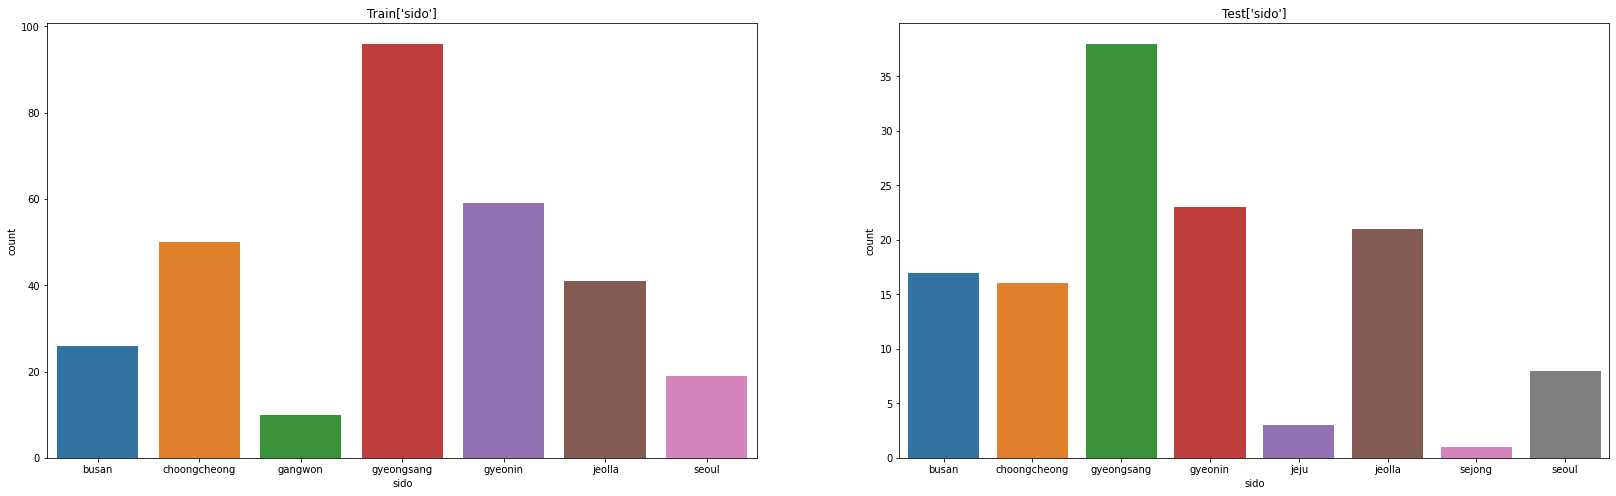

In [487]:
# sido distribution in alphabetical order
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.countplot(data=train.sort_values(by="sido"), x="sido", ax=ax[0]).set_title("Train['sido']")
sns.countplot(data=test.sort_values(by="sido"), x="sido", ax=ax[1]).set_title("Test['sido']")
plt.show()

- train에만: gangwon
- test에만: jeju

### sgg: 병원의 시군구 자료 
- sido 자료에 시군구 자료가 포함됨으로 sgg 변수 삭제

In [ ]:
train.drop('sgg', axis=1, inplace=True)
test.drop('sgg', axis=1, inplace=True)

### openDate: 병원 설립일

In [ ]:
# 'openDate' 결측치 개수 확인
train['openDate'].isnull().sum(), test['openDate'].isnull().sum()

(0, 1)

In [ ]:
# 'openDate'를 int64형에서 string형으로 변환
train['openDate'] = train['openDate'].astype(str)

test['openDate'] = test['openDate'].fillna(0).astype(int) # test 결측치 0으로 치환
test['openDate'] = test['openDate'].astype(str)

In [ ]:
# 자료형을 datetime 오브젝트로 변환하여 저장
train['openDate'] = pd.to_datetime(train['openDate'])
test['openDate'] = pd.to_datetime(test['openDate'], errors='coerce')

In [ ]:
display(train['openDate'])
display(test['openDate'])

0     2007-12-28
1     1997-04-01
2     2016-12-28
3     2000-08-14
4     2005-09-01
         ...    
296   2005-02-11
297   2014-06-18
298   1983-07-05
299   2007-01-01
300   2001-10-17
Name: openDate, Length: 301, dtype: datetime64[ns]

0     1998-11-25
1     2016-03-09
2     1989-04-27
3     2010-02-26
4     2004-06-04
         ...    
122   2001-10-12
123   2001-05-30
124   2001-01-01
125   2001-02-01
126   1996-12-16
Name: openDate, Length: 127, dtype: datetime64[ns]

In [ ]:
train.loc[train['openDate'].dt.year==2016].isna().any(axis=1)

2      False
14      True
74     False
77     False
145    False
157    False
192    False
213    False
272    False
dtype: bool

In [ ]:
train.iloc[14]

inst_id                                26
OC                                      1
sido                                ulsan
sgg                                   127
openDate              2016-05-31 00:00:00
bedCount                            237.0
instkind                 general_hospital
revenue1                              NaN
salescost1                            NaN
sga1                                  NaN
salary1                               NaN
noi1                                  NaN
noe1                                  NaN
interest1                             NaN
ctax1                                 NaN
profit1                               NaN
liquidAsset1                          NaN
quickAsset1                           NaN
receivableS1                          NaN
inventoryAsset1                       NaN
nonCAsset1                            NaN
tanAsset1                             NaN
OnonCAsset1                           NaN
receivableL1                      

In [ ]:
train.loc[train['openDate'].dt.year==2017]

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
58,92,1,busan,71,2017-06-07,44.0,nursing_hospital,1.033288e+10,4.075620e+09,6.000945e+09,...,8.622036e+09,4.456688e+09,2.291334e+09,4.165349e+09,4.165349e+09,2.378710e+09,513764252.0,75.0,75.0,same
62,96,1,busan,64,2017-06-02,128.0,nursing_hospital,5.236406e+08,2.306773e+07,8.355775e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,38.0,NaN,NaN
172,259,1,gyeongbuk,25,2017-05-02,162.0,nursing_hospital,1.114522e+09,0.000000e+00,2.552348e+09,...,1.876978e+09,2.900000e+07,2.900000e+07,1.847978e+09,1.847978e+09,9.148471e+08,0.0,70.0,0.0,same
206,298,1,gyeongnam,32,2017-01-20,160.0,nursing_hospital,3.279139e+09,3.726966e+08,3.507972e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,103.0,NaN
242,345,1,busan,69,2017-04-20,0.0,traditional_clinic,6.845503e+08,0.000000e+00,5.619356e+08,...,6.957960e+07,6.920960e+07,0.000000e+00,3.700000e+05,0.000000e+00,1.900197e+09,0.0,NaN,NaN,NaN
261,366,0,gyeonggi,98,2017-01-20,0.0,traditional_clinic,7.162790e+09,8.758944e+08,5.387362e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,79.0,70.0,same


- 2017년에 설립된 병원의 경우, 2016년 회계 년도 자료가 없어야 하는 거 아닌지...

In [ ]:
# openDate의 날짜를 제외한 년도와 월을 새로운 컬럼으로 만든다.
train["openYear"] = train["openDate"].dt.year
train["openMonth"] = train["openDate"].dt.month
test["openYear"] = test["openDate"].dt.year
test["openMonth"] = test["openDate"].dt.month

# 기존의 openDate 열 삭제
train.drop(columns="openDate", axis=1, inplace=True)
test.drop(columns="openDate", axis=1, inplace=True)

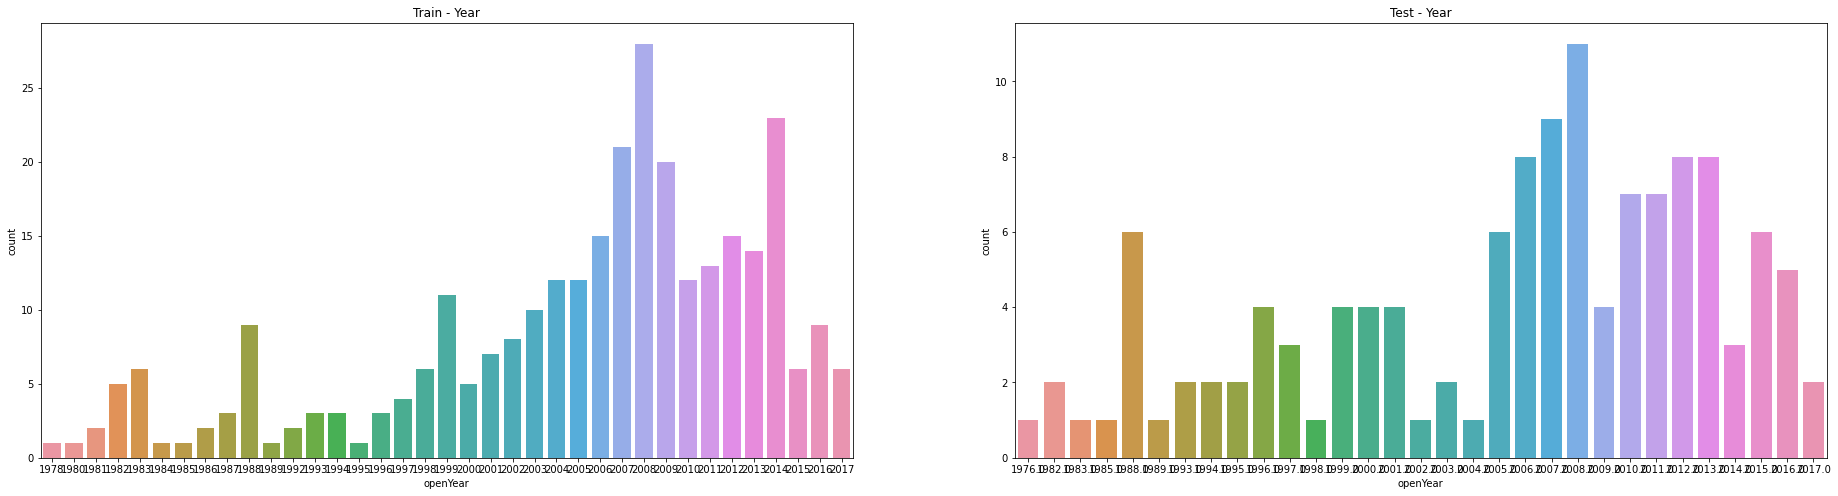

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(32, 8))
sns.countplot(data=train, x="openYear", ax=ax[0]).set_title("Train - Year")
sns.countplot(data=test, x="openYear", ax=ax[1]).set_title("Test - Year")
plt.show()

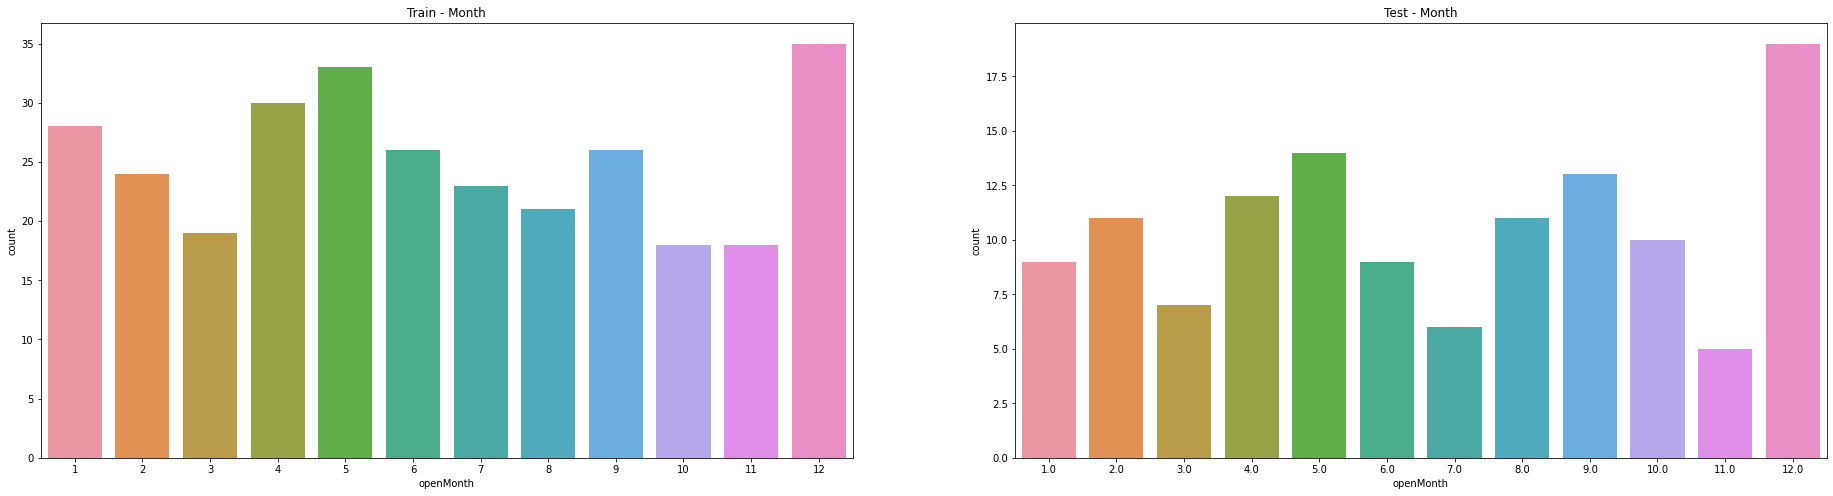

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(32, 8))
sns.countplot(data=train, x="openMonth", ax=ax[0]).set_title("Train - Month")
sns.countplot(data=test, x="openMonth", ax=ax[1]).set_title("Test - Month")
plt.show()

In [ ]:
train[['OC', 'openMonth', 'openYear']].corr()

,OC,openMonth,openYear
OC,1.000000,0.014947,-0.049533
openMonth,0.014947,1.000000,0.077255
openYear,-0.049533,0.077255,1.000000


- 병원 설립일은 'OC'와 크게 상관관계를 보이지 않음

### ownerChange: 대표자의 변동

In [ ]:
# 'ownerChange' 결측치 개수 확인
train['ownerChange'].isnull().sum(), test['ownerChange'].isnull().sum()

(12, 15)

In [ ]:
train['ownerChange'].value_counts()

same      247
change     42
Name: ownerChange, dtype: int64

- same, change 외에 unknown을 결측치에 넣자.

In [ ]:
train['ownerChange'] = train['ownerChange'].fillna('unknown')
test['ownerChange'] = test['ownerChange'].fillna('unknown')

In [ ]:
train['ownerChange'].value_counts()

same       247
change      42
unknown     12
Name: ownerChange, dtype: int64

### instkind: 병원의 종류

In [ ]:
# 'instkind' 결측치 개수 확인
train['instkind'].isnull().sum(), test['instkind'].isnull().sum()

(1, 2)

In [ ]:
display(train[train["instkind"].isnull()])
display(test[test["instkind"].isnull()])

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
193,281,0,gyeonggi,12,2012-12-13,NaN,NaN,305438818.0,22416139.0,467475340.0,...,0.0,0.0,0.0,0.0,0.0,15.0,15.0,change,2012,12


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
120,413,NaN,gyeonggi,168,NaT,49.0,NaN,5.583625e+08,7.443415e+07,5.482900e+08,...,0.0,0.000000e+00,0.000000e+00,0.0,0.0,21,21,same,NaN,NaN
125,430,NaN,jeju,76,2001-02-01,NaN,NaN,4.892710e+10,4.157148e+10,4.721485e+09,...,0.0,2.871805e+10,2.563120e+10,-205062936.0,0.0,363,343,same,2001.0,2.0


In [ ]:
train['instkind'].value_counts()

nursing_hospital        144
hospital                 88
general_hospital         37
clinic                   18
traditional_hospital      8
traditional_clinic        4
dental_clinic             1
Name: instkind, dtype: int64

In [ ]:
test['instkind'].value_counts()

nursing_hospital        63
hospital                36
general_hospital        19
clinic                   4
traditional_clinic       2
traditional_hospital     1
Name: instkind, dtype: int64

- train데이터에만 dental_clinic 1개의 데이터가 있음으로 clinic에 포함시켜도 무방

In [ ]:
train['instkind'] = train['instkind'].replace('dental_clinic','clinic')

- nursing_hospital: 요양병원
- general_hospital: 입원환자 100명 이상 수용 가능
- hospital: 입원 환자 30명 이상 100명 미만 수용 가능
- clinic: 입원 환자 30명 이하 수용 가능
- traditional: 침술과 한약으로 치료하는 의료 기관
  - traditional clinic
  - traditional hospital


### bedCount: 병원이 갖추고 있는 병상의 수

In [ ]:
# 'bedCount' 결측치 개수 확인
train['bedCount'].isnull().sum(), test['bedCount'].isnull().sum()

(5, 8)

In [ ]:
display(train[train["bedCount"].isnull()])
display(test[test["bedCount"].isnull()])

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
71,107,0,jeonbuk,26,1999-08-05,NaN,traditional_hospital,4.131858e+09,1.436118e+08,3.529097e+09,...,2.442951e+09,2.557878e+07,0.000000e+00,2.487828e+09,0.000000e+00,85.0,74.0,same,1999,8
193,281,0,gyeonggi,12,2012-12-13,NaN,NaN,3.054388e+08,2.241614e+07,4.674753e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,15.0,15.0,change,2012,12
297,423,0,choongnam,159,2014-06-18,NaN,hospital,6.717144e+09,8.200000e+09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,79.0,same,2014,6
298,426,0,gyeongbuk,107,1983-07-05,NaN,hospital,0.000000e+00,0.000000e+00,5.479428e+07,...,0.000000e+00,4.199124e+09,2.498749e+09,3.259161e+09,0.000000e+00,NaN,NaN,unknown,1983,7
300,428,1,seoul,79,2001-10-17,NaN,traditional_hospital,1.340971e+09,8.108450e+08,5.043409e+08,...,0.000000e+00,2.225928e+09,2.190000e+09,5.536178e+09,6.269440e+09,15.0,15.0,same,2001,10


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
10,24,NaN,gyeonggi,169,2007-11-09,NaN,traditional_clinic,7.034041e+10,1.570361e+10,5.177418e+10,...,7.749623e+09,4.727596e+10,3.331840e+10,9.818765e+09,8.483183e+09,532,409,same,2007.0,11.0
22,64,NaN,jeonbuk,34,2006-06-29,NaN,hospital,3.207567e+09,2.656878e+07,3.242981e+09,...,0.000000e+00,1.673685e+10,1.028108e+10,1.624724e+10,0.000000e+00,NaN,NaN,unknown,2006.0,6.0
40,123,NaN,jeonnam,144,2008-12-10,NaN,nursing_hospital,4.647433e+09,2.328483e+08,4.043634e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,86,96,same,2008.0,12.0
78,229,NaN,gyeongnam,32,1988-10-17,NaN,hospital,4.865826e+09,3.286408e+08,4.518516e+09,...,4.367571e+09,3.200000e+08,3.200000e+08,5.824119e+09,4.260808e+09,130,65,change,1988.0,10.0
84,258,NaN,busan,72,2011-12-22,NaN,nursing_hospital,8.721791e+08,4.899072e+07,7.694744e+08,...,3.539000e+08,3.416350e+08,3.167499e+08,5.755372e+08,0.000000e+00,25,26,change,2011.0,12.0
99,341,NaN,busan,66,2010-02-26,NaN,nursing_hospital,3.944159e+07,1.835644e+06,1.139939e+08,...,0.000000e+00,1.890000e+09,1.890000e+09,1.963282e+09,0.000000e+00,32,32,unknown,2010.0,2.0
123,425,NaN,gyeonggi,74,2001-05-30,NaN,traditional_hospital,1.833906e+10,0.000000e+00,1.760117e+10,...,0.000000e+00,1.799886e+09,1.740000e+09,8.574502e+09,7.136681e+09,132,137,same,2001.0,5.0
125,430,NaN,jeju,76,2001-02-01,NaN,NaN,4.892710e+10,4.157148e+10,4.721485e+09,...,0.000000e+00,2.871805e+10,2.563120e+10,-2.050629e+08,0.000000e+00,363,343,same,2001.0,2.0


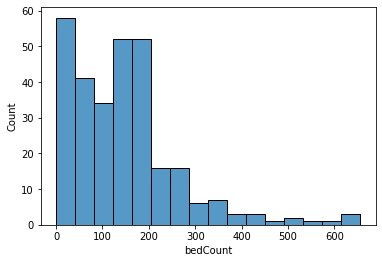

In [ ]:
sns.histplot(data=train, x="bedCount")

- 다소 skew된 분포로 로그 변환 고려

In [ ]:
# 병원의 종류에 따른 bedCount
train.groupby('instkind')['bedCount'].mean()

instkind
clinic                    4.444444
dental_clinic             0.000000
general_hospital        261.567568
hospital                 96.220930
nursing_hospital        172.340278
traditional_clinic        0.000000
traditional_hospital     46.666667
Name: bedCount, dtype: float64

In [ ]:
train.groupby('instkind')['employee1'].mean()

instkind
clinic                   84.764706
dental_clinic           107.000000
general_hospital        406.216216
hospital                125.488095
nursing_hospital         97.822695
traditional_clinic       79.666667
traditional_hospital     45.000000
Name: employee1, dtype: float64

In [ ]:
test.loc[test['inst_id']==430]

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
125,430,NaN,jeju,76,2001-02-01,NaN,NaN,4.892710e+10,4.157148e+10,4.721485e+09,...,0.0,2.871805e+10,2.563120e+10,-205062936.0,0.0,363,343,same,2001.0,2.0


In [ ]:
test.loc[test['inst_id']==413]

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
120,413,NaN,gyeonggi,168,NaT,49.0,NaN,558362470.0,74434148.0,548290004.0,...,0.0,0.0,0.0,0.0,0.0,21,21,same,NaN,NaN


### employee1 : 고용한 총 직원의 수, 2017년
### employee2 : 고용한 총 직원의 수, 2016년

In [ ]:
# 'employee1' 결측치 개수 확인
train['employee1'].isnull().sum(), test['employee1'].isnull().sum()

(10, 8)

In [ ]:
train[train['employee1'].isnull()]

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
48,74,1,seoul,1,1994-04-25,28.0,traditional_hospital,8.872427e+09,9.641249e+08,7.638920e+09,...,5.958278e+09,5.956278e+09,4.992758e+09,2.000000e+06,0.000000e+00,3.625952e+09,0.0,NaN,NaN,ownerChange
60,94,1,gangwon,128,2003-12-01,244.0,nursing_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ownerChange
93,140,0,gyeongbuk,114,2007-04-20,203.0,hospital,5.423357e+09,0.000000e+00,5.212041e+09,...,2.733619e+09,1.406195e+08,0.000000e+00,2.590000e+09,2.590000e+09,3.752184e+09,0.0,NaN,NaN,ownerChange
206,298,1,gyeongnam,32,2017-01-20,160.0,nursing_hospital,3.279139e+09,3.726966e+08,3.507972e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,103.0,ownerChange
212,306,0,jeonnam,33,1999-06-03,66.0,nursing_hospital,2.233031e+10,8.484657e+08,1.849255e+10,...,1.563217e+10,1.288180e+10,0.000000e+00,2.750371e+09,0.000000e+00,1.384958e+10,0.0,NaN,NaN,ownerChange
242,345,1,busan,69,2017-04-20,0.0,traditional_clinic,6.845503e+08,0.000000e+00,5.619356e+08,...,6.957960e+07,6.920960e+07,0.000000e+00,3.700000e+05,0.000000e+00,1.900197e+09,0.0,NaN,NaN,ownerChange
258,363,1,gyeongbuk,95,2014-12-19,0.0,clinic,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ownerChange
263,369,1,gangwon,100,2002-01-23,39.0,hospital,3.007769e+09,1.197756e+09,2.258240e+09,...,1.883430e+09,5.315201e+08,2.000000e+08,1.351910e+09,1.201910e+09,1.017573e+09,226197450.0,NaN,NaN,ownerChange
285,407,1,gyeongbuk,160,1988-11-04,119.0,hospital,9.618709e+09,0.000000e+00,9.751211e+09,...,4.416916e+09,1.524426e+09,0.000000e+00,2.892490e+09,5.462400e+08,4.902827e+09,0.0,NaN,NaN,ownerChange
298,426,0,gyeongbuk,107,1983-07-05,NaN,hospital,0.000000e+00,0.000000e+00,5.479428e+07,...,6.370097e+09,2.170973e+09,0.000000e+00,4.199124e+09,2.498749e+09,3.259161e+09,0.0,NaN,NaN,ownerChange


In [ ]:
test['employee1'].unique()

array(['693', '379', nan, '760', '437', '386', '727', '377', '17', '532',
       '128', '1,637', '1,816', '566', '104', '244', '187', '431', '150',
       '361', '41', '110', '457', '210', '344', '250', '48', '109', '292',
       '121', '83', '100', '154', '134', '107', '89', '86', '69', '93',
       '324', '1,065', '340', '55', '22', '300', '120', '260', '143',
       '78', '81', '46', '74', '155', '130', '122', '59', '180', '855',
       '30', '96', '75', '44', '203', '70', '129', '67', '85', '236',
       '29', '116', '37', '25', '45', '47', '52', '56', '76', '125', '80',
       '63', '90', '190', '222', '32', '66', '224', '61', '28', '604',
       '33', '16', '36', '106', '60', '19', '49', '21', '111', '560',
       '132', '363'], dtype=object)

In [ ]:
test["employee1"] = test["employee1"].str.replace(",","").astype("float")
test["employee2"] = test["employee2"].str.replace(",","").astype("float")

### revenue1, revenue2: 매출액

In [ ]:
# 'revenue1' 결측치 개수 확인
train['revenue1'].isnull().sum(), test['revenue1'].isnull().sum()

(8, 2)

In [ ]:
# 'revenue2' 결측치 개수 확인
train['revenue2'].isnull().sum(), test['revenue2'].isnull().sum()

(8, 2)

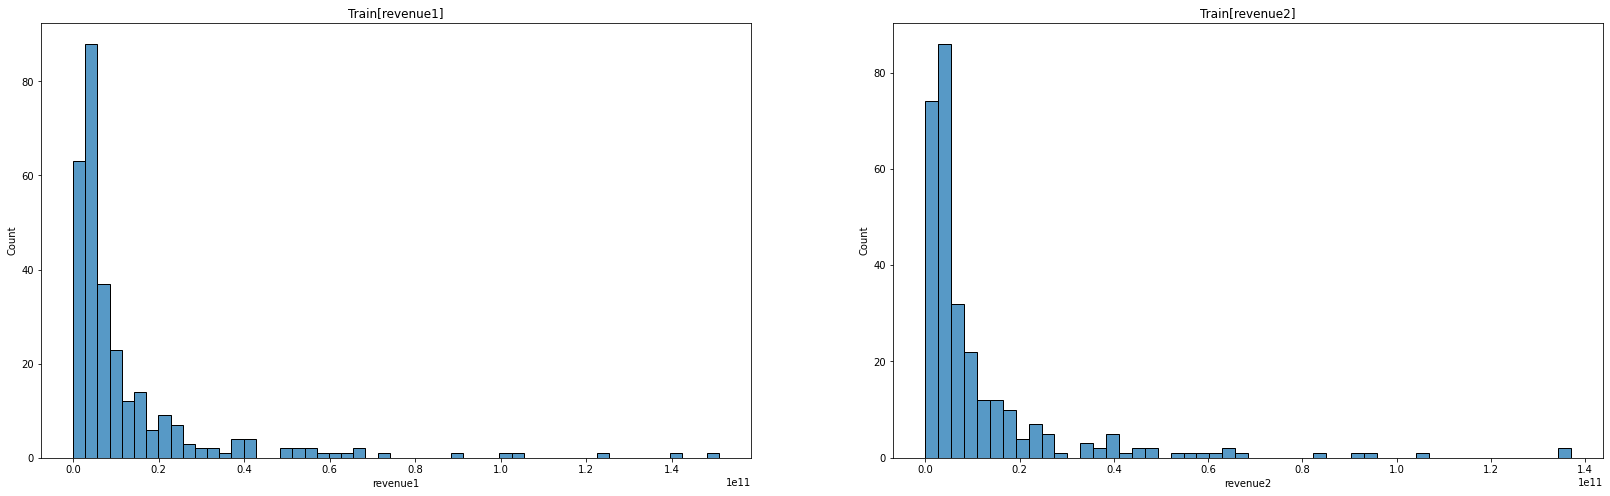

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.histplot(data=train['revenue1'], ax=ax[0]).set_title("Train[revenue1]")
sns.histplot(data=train['revenue2'], ax=ax[1]).set_title("Train[revenue2]")
plt.show()

- 로그 변환 고려

### 그 외 연속형 변수

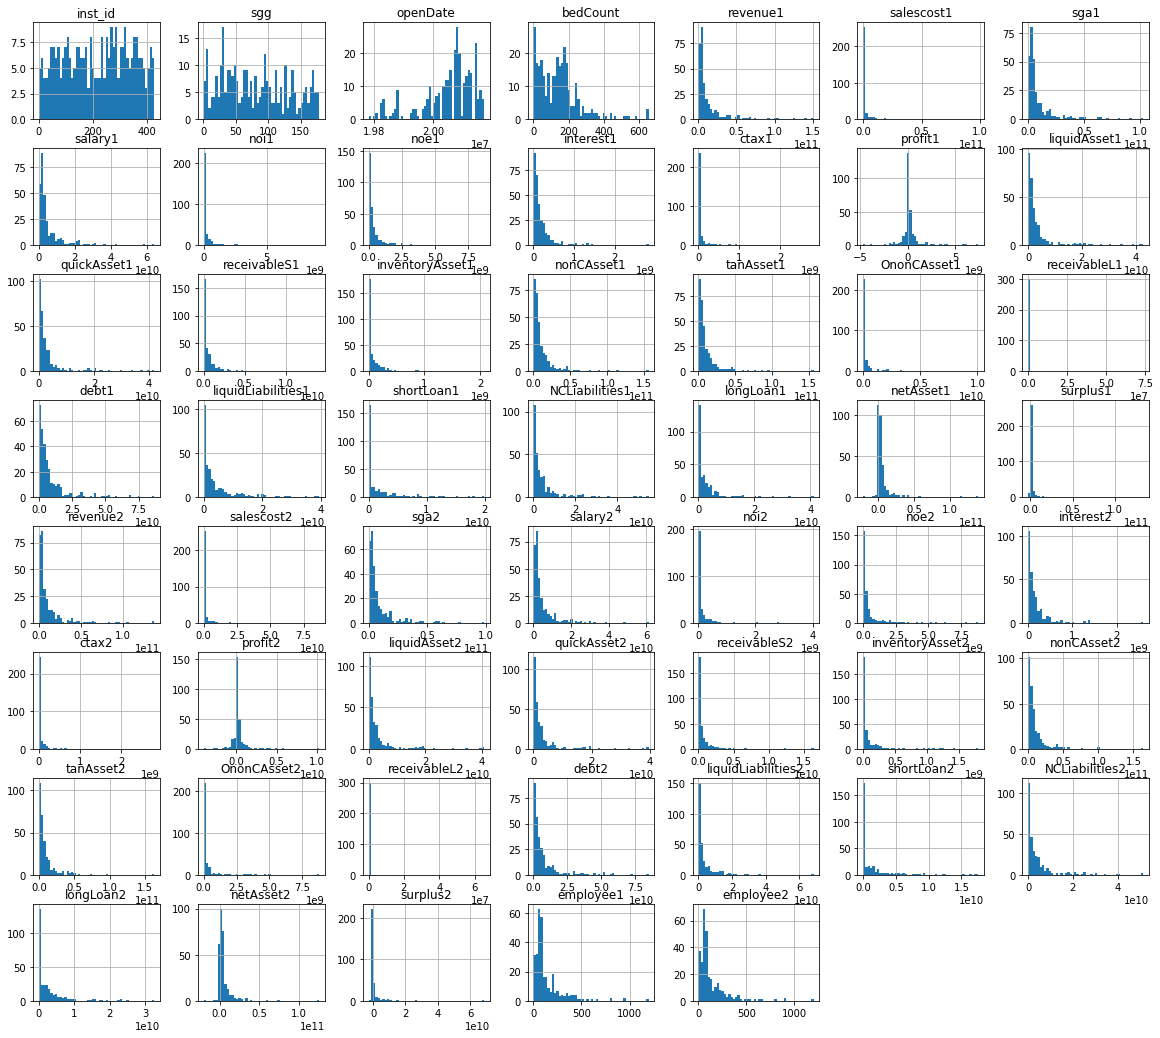

In [ ]:
_ = train.hist(bins=50, figsize=(20, 18))

- 대부분 right-skewed -> 로그 변환 고려
- profit1, netAsset1, surplus1, profit2 확인 필요
- receiveable_1, receiveable_2 이상치(?) 확인 필요

### profit1, profit2: 당기순이익

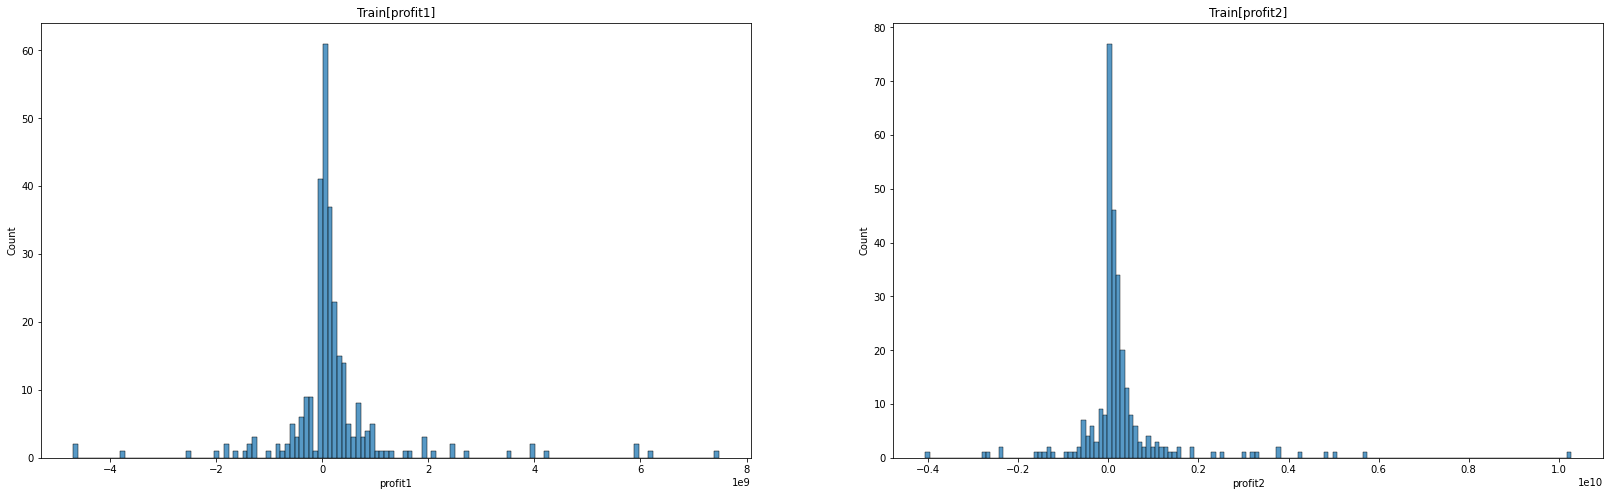

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.histplot(data=train['profit1'], ax=ax[0]).set_title("Train[profit1]")
sns.histplot(data=train['profit2'], ax=ax[1]).set_title("Train[profit2]")
plt.show()

- 표준화 고려

### receivableL1, receivableL2: 장기 미수금 (2017, 2016)

In [ ]:
# 'receivableL1' 결측치 개수 확인
train['receivableL1'].isnull().sum(), test['receivableL1'].isnull().sum()

(8, 2)

In [ ]:
# 'receivableL2' 결측치 개수 확인
train['receivableL2'].isnull().sum(), test['receivableL2'].isnull().sum()

(8, 2)

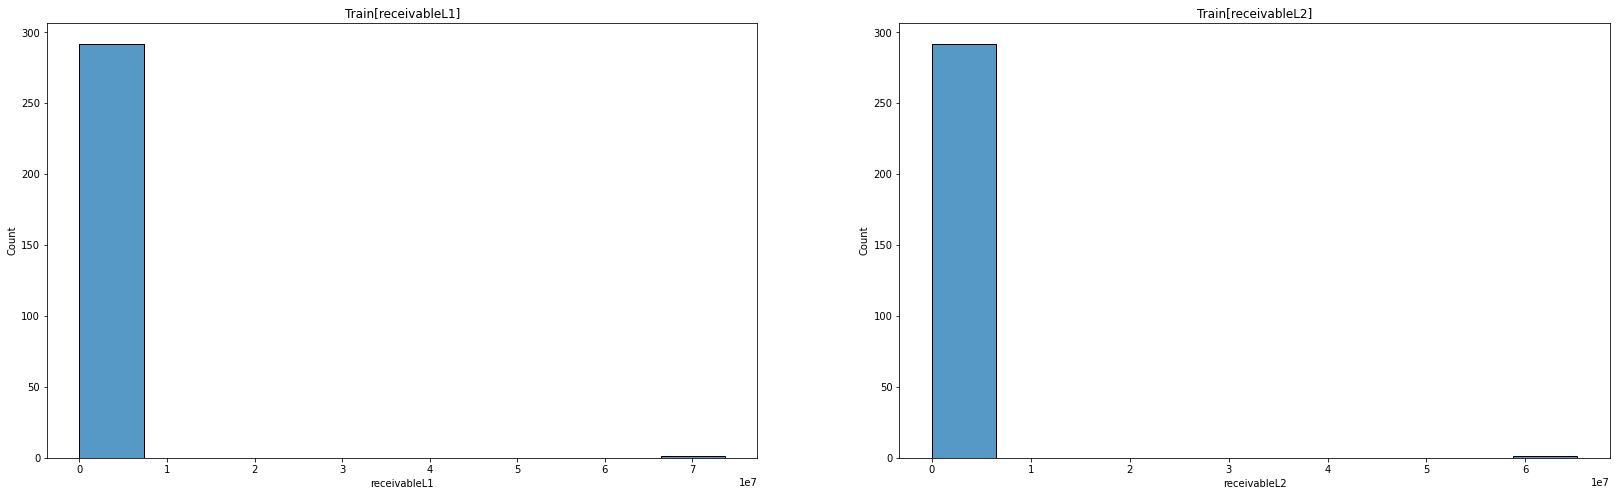

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.histplot(data=train['receivableL1'], ax=ax[0]).set_title("Train[receivableL1]")
sns.histplot(data=train['receivableL2'], ax=ax[1]).set_title("Train[receivableL2]")
plt.show()

In [ ]:
train['receivableL1'].value_counts()

0.0           292
73742310.0      1
Name: receivableL1, dtype: int64

In [ ]:
train[train['receivableL1']>0]

,inst_id,OC,sido,sgg,bedCount,instkind,revenue1,salescost1,sga1,salary1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
299,427,0,gyeon-in,169,180.0,nursing_hospital,2.116892e+09,268174808.0,3.286245e+09,2.231944e+09,...,0.0,0.0,0.0,0.0,0.0,100.0,NaN,unknown,2007,1


In [ ]:
train['receivableL2'].value_counts()

0.0           292
65242310.0      1
Name: receivableL2, dtype: int64

In [ ]:
train[train['receivableL2']>0]

,inst_id,OC,sido,sgg,bedCount,instkind,revenue1,salescost1,sga1,salary1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
299,427,0,gyeon-in,169,180.0,nursing_hospital,2.116892e+09,268174808.0,3.286245e+09,2.231944e+09,...,0.0,0.0,0.0,0.0,0.0,100.0,NaN,unknown,2007,1


- train데이터에 1개의 병원 데이터의 경우에만 장기 미수금 있음
- 나머지는 장기 미수금 없음

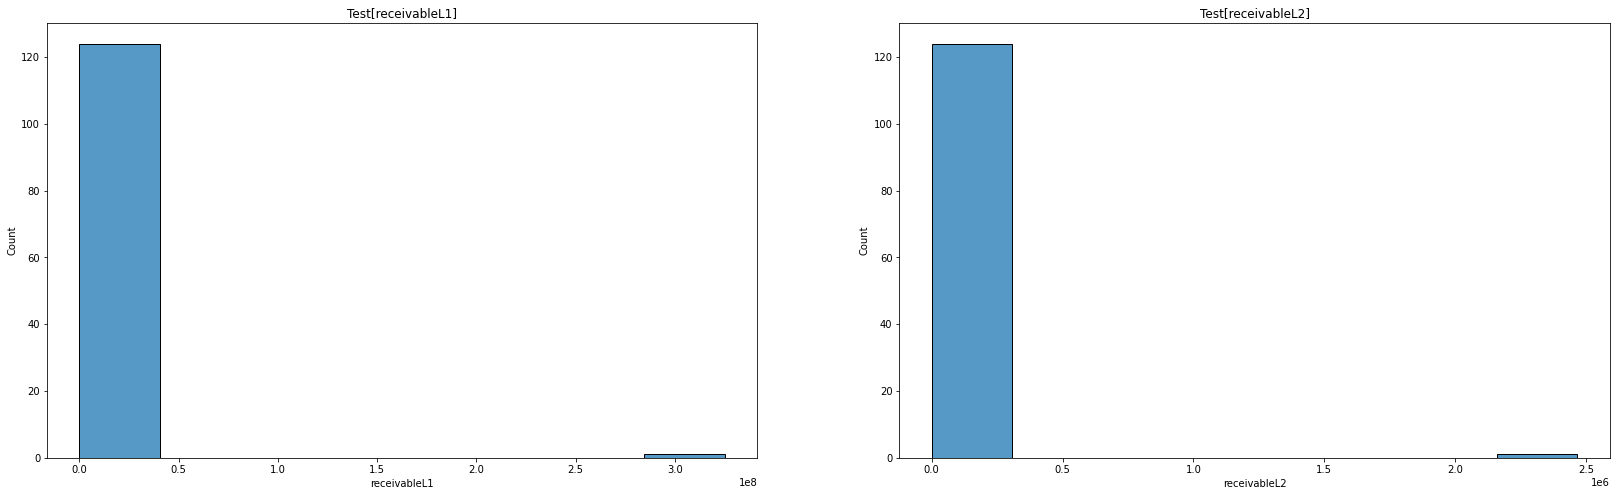

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.histplot(data=test['receivableL1'], ax=ax[0]).set_title("Test[receivableL1]")
sns.histplot(data=test['receivableL2'], ax=ax[1]).set_title("Test[receivableL2]")
plt.show()

- test 데이터의 경우에도 유사한 경향을 보임

### netAsset1, netAsset2: 순자산통계 (2017, 2016)

In [ ]:
# 'netAsset1' 결측치 개수 확인
train['netAsset1'].isnull().sum(), test['netAsset1'].isnull().sum()

(8, 2)

In [ ]:
# 'netAsset2' 결측치 개수 확인
train['netAsset2'].isnull().sum(), test['netAsset2'].isnull().sum()

(8, 2)

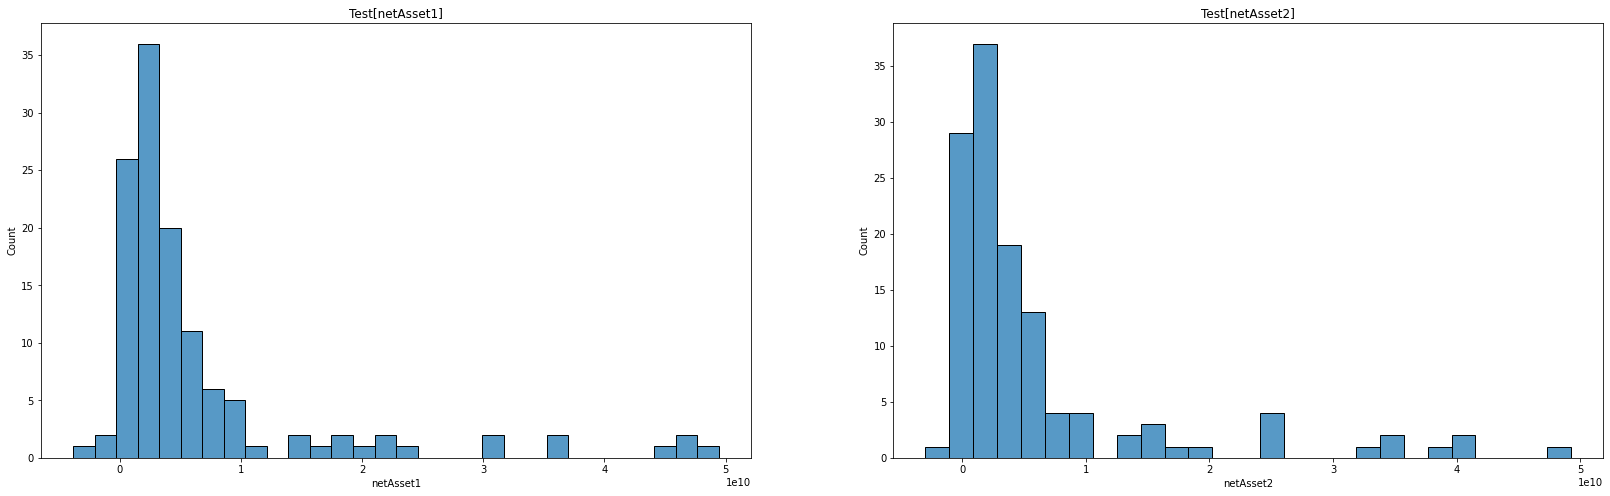

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.histplot(data=test['netAsset1'], ax=ax[0]).set_title("Test[netAsset1]")
sns.histplot(data=test['netAsset2'], ax=ax[1]).set_title("Test[netAsset2]")
plt.show()

In [ ]:
train[train['netAsset1']<0]

,inst_id,OC,sido,sgg,bedCount,instkind,revenue1,salescost1,sga1,salary1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,openYear,openMonth
102,152,1,gyeongsang,156,176.0,nursing_hospital,6.571259e+09,4.303759e+08,5.682418e+09,3.510649e+09,...,1.704781e+09,4.314022e+09,4.297954e+09,6.083964e+07,6.062395e+07,73.0,74.0,same,2007,9
133,196,1,choongcheong,165,142.0,nursing_hospital,4.631822e+09,1.754204e+08,4.156457e+09,2.431562e+09,...,8.118447e+08,5.320735e+09,3.800000e+09,-6.032148e+09,0.000000e+00,52.0,52.0,same,2009,12
136,202,1,jeolla,110,139.0,hospital,9.212685e+09,1.532127e+09,7.146826e+09,3.647429e+09,...,8.370000e+08,3.390000e+09,2.890000e+09,-1.292508e+09,0.000000e+00,125.0,125.0,change,1988,6
172,259,1,gyeongsang,25,162.0,nursing_hospital,1.114522e+09,0.000000e+00,2.552348e+09,1.598551e+09,...,2.900000e+07,1.847978e+09,1.847978e+09,9.148471e+08,0.000000e+00,70.0,0.0,same,2017,5
183,271,1,seoul,4,155.0,general_hospital,3.242731e+10,0.000000e+00,3.188290e+10,1.198974e+10,...,0.000000e+00,2.511077e+10,2.252469e+10,-2.014780e+10,0.000000e+00,207.0,213.0,same,2012,4
203,295,1,jeolla,29,30.0,hospital,1.048114e+09,3.936811e+07,8.477251e+08,5.630889e+08,...,0.000000e+00,5.065575e+09,0.000000e+00,-1.871290e+09,-2.781507e+09,25.0,55.0,same,2009,9
268,376,1,gyeongsang,111,45.0,hospital,2.746591e+09,4.698519e+08,3.343374e+09,1.332867e+09,...,0.000000e+00,5.142799e+10,3.256147e+10,1.814845e+09,1.375345e+08,30.0,30.0,change,1988,2
275,386,1,gyeongsang,132,113.0,nursing_hospital,2.360720e+09,0.000000e+00,2.346809e+09,1.340152e+09,...,0.000000e+00,5.202417e+09,3.941668e+09,-4.125217e+09,0.000000e+00,48.0,57.0,change,2006,8


- 순자산통계가 음수인 경우도 있기 때문에 로그변환 말고 feature scaling 고려

## | 전처리 종합
---

In [488]:
# 전처리 종합 코드
test = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/test.csv")
train = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/train.csv")
sub = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/submission_sample.csv")

train['OC'].replace({'open':1, ' close':0}, inplace=True)

train.drop('sgg', axis=1, inplace=True)
test.drop('sgg', axis=1, inplace=True)

train.drop('inst_id', axis=1, inplace=True) #'inst_id' 행 제거
test.drop('inst_id', axis=1, inplace=True)

train['sido'] = train['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})
test['sido'] = test['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejonga':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})

train['openDate'] = train['openDate'].astype(str)
test['openDate'] = test['openDate'].fillna(0).astype(int) # test 결측치 0으로 치환
test['openDate'] = test['openDate'].astype(str)
train['openDate'] = pd.to_datetime(train['openDate'])
test['openDate'] = pd.to_datetime(test['openDate'], errors='coerce')
train["openYear"] = train["openDate"].dt.year
train["openMonth"] = train["openDate"].dt.month
test["openYear"] = test["openDate"].dt.year
test["openMonth"] = test["openDate"].dt.month
train.drop(columns="openDate", axis=1, inplace=True)
test.drop(columns="openDate", axis=1, inplace=True)


train['ownerChange'] = train['ownerChange'].fillna('unknown')
test['ownerChange'] = test['ownerChange'].fillna('unknown')

train['instkind'] = train['instkind'].replace('dental_clinic','clinic')

test["employee1"] = test["employee1"].str.replace(",","").astype("float")
test["employee2"] = test["employee2"].str.replace(",","").astype("float")

- 범주형 변수: sido, instkind, ownerChange -> one-hot encoding

In [489]:
train_one =pd.get_dummies(data=train)
test_one =pd.get_dummies(data=test)

In [490]:
train_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OC                             301 non-null    int64  
 1   bedCount                       296 non-null    float64
 2   revenue1                       293 non-null    float64
 3   salescost1                     293 non-null    float64
 4   sga1                           293 non-null    float64
 5   salary1                        293 non-null    float64
 6   noi1                           293 non-null    float64
 7   noe1                           293 non-null    float64
 8   interest1                      293 non-null    float64
 9   ctax1                          293 non-null    float64
 10  profit1                        293 non-null    float64
 11  liquidAsset1                   293 non-null    float64
 12  quickAsset1                    293 non-null    flo

- 일부 연속형 변수 -> log transformation 

In [491]:
# 넘파이의 log1p( )를 이용하여 연속형 변수 로그 변환 
cont = train_one.iloc[:,1:52]
cont

,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
0,175.0,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,...,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0
1,410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0
2,468.0,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0
3,353.0,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,...,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0
4,196.0,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,...,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,214.0,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,1.875761e+08,0.0,5.943868e+08,...,0.0,9.423771e+09,2.618201e+09,0.000000e+00,6.805570e+09,5.930000e+09,5.379502e+09,8.116416e+08,193.0,141.0
297,NaN,6.717144e+09,8.200000e+09,0.000000e+00,0.000000e+00,186359.0,1.398513e+08,1.296975e+08,0.0,-1.622521e+09,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,79.0
298,NaN,0.000000e+00,0.000000e+00,5.479428e+07,7.500000e+06,121022160.0,1.379810e+08,1.379810e+08,0.0,-7.175308e+07,...,0.0,6.370097e+09,2.170973e+09,0.000000e+00,4.199124e+09,2.498749e+09,3.259161e+09,0.000000e+00,NaN,NaN
299,180.0,2.116892e+09,2.681748e+08,3.286245e+09,2.231944e+09,123665065.0,5.366919e+08,5.143688e+08,0.0,-1.850554e+09,...,65242310.0,6.392336e+08,6.400000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,100.0,NaN


In [391]:
# 음수 값 없는 열
neg_col = []
for col in cont.columns:
  for i in cont[col]:
    if i < 0:
      neg_col.append(col)
      break

print(neg_col)

non_neg_col = list(cont.columns)
for i in neg_col:
  non_neg_col.remove(i)

print(non_neg_col)

['profit1', 'netAsset1', 'surplus1', 'profit2', 'netAsset2', 'surplus2']
['bedCount', 'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1', 'interest1', 'ctax1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1', 'longLoan1', 'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2', 'liquidAsset2', 'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2', 'employee1', 'employee2']


In [392]:
# 로그 변환
train_one[non_neg_col] = np.log1p(train_one[non_neg_col])

In [393]:
train_one[non_neg_col]

,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,liquidAsset1,...,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,employee1,employee2
0,5.170484,22.162515,0.000000,22.099796,21.433189,16.566138,16.539187,16.398469,17.269990,20.735886,...,21.592994,18.798422,0.000000,20.447504,19.222130,0.000000,20.099863,19.781657,4.143135,4.174387
1,6.018593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.687109,6.701960
2,6.150603,20.727778,20.060616,19.918561,19.507228,11.240552,10.308986,0.000000,0.000000,19.422937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.459586,0.693147
3,5.869297,25.006954,0.000000,24.981392,24.182293,20.042488,20.954034,20.902985,18.973242,23.291406,...,24.274484,22.088313,0.000000,24.354384,23.557572,22.944579,23.755157,23.437961,6.498282,6.498282
4,5.283204,24.615974,0.000000,24.587275,23.920337,18.537150,21.073281,20.991191,0.000000,22.566524,...,24.543819,20.486709,0.000000,24.663538,24.126880,23.590810,23.784786,23.370010,5.332719,5.288267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5.370638,22.753346,19.844626,22.498747,21.966804,17.555534,20.427474,19.049695,0.000000,21.744494,...,23.216856,18.157453,0.000000,22.966501,21.685753,0.000000,22.641007,22.503290,5.267858,4.955827
297,NaN,22.627929,22.827400,0.000000,0.000000,12.135436,18.756090,18.680716,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.382027,4.382027
298,NaN,0.000000,0.000000,17.819096,15.830414,18.611484,18.742626,18.742626,0.000000,22.075806,...,22.413317,17.784997,0.000000,22.574881,21.498441,0.000000,22.158142,21.639056,NaN,NaN
299,5.198497,21.473215,19.407150,21.913011,21.526139,18.633087,20.100935,20.058451,0.000000,22.318477,...,22.214247,0.000000,17.993619,20.275780,22.579564,0.000000,0.000000,0.000000,4.615121,NaN


- 음수 값을 포함하는 연속형 변수: standardization

In [396]:
train_one[non_neg_col]

,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,liquidAsset1,...,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,employee1,employee2
0,5.170484,22.162515,0.000000,22.099796,21.433189,16.566138,16.539187,16.398469,17.269990,20.735886,...,21.592994,18.798422,0.000000,20.447504,19.222130,0.000000,20.099863,19.781657,4.143135,4.174387
1,6.018593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.687109,6.701960
2,6.150603,20.727778,20.060616,19.918561,19.507228,11.240552,10.308986,0.000000,0.000000,19.422937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.459586,0.693147
3,5.869297,25.006954,0.000000,24.981392,24.182293,20.042488,20.954034,20.902985,18.973242,23.291406,...,24.274484,22.088313,0.000000,24.354384,23.557572,22.944579,23.755157,23.437961,6.498282,6.498282
4,5.283204,24.615974,0.000000,24.587275,23.920337,18.537150,21.073281,20.991191,0.000000,22.566524,...,24.543819,20.486709,0.000000,24.663538,24.126880,23.590810,23.784786,23.370010,5.332719,5.288267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5.370638,22.753346,19.844626,22.498747,21.966804,17.555534,20.427474,19.049695,0.000000,21.744494,...,23.216856,18.157453,0.000000,22.966501,21.685753,0.000000,22.641007,22.503290,5.267858,4.955827
297,NaN,22.627929,22.827400,0.000000,0.000000,12.135436,18.756090,18.680716,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.382027,4.382027
298,NaN,0.000000,0.000000,17.819096,15.830414,18.611484,18.742626,18.742626,0.000000,22.075806,...,22.413317,17.784997,0.000000,22.574881,21.498441,0.000000,22.158142,21.639056,NaN,NaN
299,5.198497,21.473215,19.407150,21.913011,21.526139,18.633087,20.100935,20.058451,0.000000,22.318477,...,22.214247,0.000000,17.993619,20.275780,22.579564,0.000000,0.000000,0.000000,4.615121,NaN


In [398]:
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(train_one[non_neg_col])
train_one[non_neg_col] = standard_scaler.transform(train_one[non_neg_col])

## | Train, test data X, y split
---

In [492]:
# 종합 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# 전처리 종종합 코드
test = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/test.csv")
train = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/train.csv")
sub = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/submission_sample.csv")

train['OC'].replace({'open':1, ' close':0}, inplace=True)

train.drop('sgg', axis=1, inplace=True)
test.drop('sgg', axis=1, inplace=True)

train.drop('inst_id', axis=1, inplace=True) #'inst_id' 행 제거
test.drop('inst_id', axis=1, inplace=True)

train['sido'] = train['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})
test['sido'] = test['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})

train['openDate'] = train['openDate'].astype(str)
test['openDate'] = test['openDate'].fillna(0).astype(int) # test 결측치 0으로 치환
test['openDate'] = test['openDate'].astype(str)
train['openDate'] = pd.to_datetime(train['openDate'])
test['openDate'] = pd.to_datetime(test['openDate'], errors='coerce')
train["openYear"] = train["openDate"].dt.year
train["openMonth"] = train["openDate"].dt.month
test["openYear"] = test["openDate"].dt.year
test["openMonth"] = test["openDate"].dt.month
train.drop(columns="openDate", axis=1, inplace=True)
test.drop(columns="openDate", axis=1, inplace=True)

train['ownerChange'] = train['ownerChange'].fillna('unknown')
test['ownerChange'] = test['ownerChange'].fillna('unknown')

train['instkind'] = train['instkind'].replace('dental_clinic','clinic')

test["employee1"] = test["employee1"].str.replace(",","").astype("float")
test["employee2"] = test["employee2"].str.replace(",","").astype("float")

train_one =pd.get_dummies(data=train)
test_one =pd.get_dummies(data=test)

cont = train_one.iloc[:,1:52]
neg_col = []
for col in cont.columns:
  for i in cont[col]:
    if i < 0:
      neg_col.append(col)
      break
non_neg_col = list(cont.columns)
for i in neg_col:
  non_neg_col.remove(i)

train_one[non_neg_col] = np.log1p(train_one[non_neg_col])
for col in neg_col:
  train_one[col] = np.log1p(train_one[col]-train_one[col].min())
test_one[non_neg_col] = np.log1p(test_one[non_neg_col])
for col in neg_col:
  test_one[col] = np.log1p(test_one[col]-test_one[col].min())

mean_cont = train_one[list(cont.columns)].mean()
train_one[list(cont.columns)] = train_one[list(cont.columns)].fillna(mean_cont)
mean_cont = test_one[list(cont.columns)].mean()
test_one[list(cont.columns)] = test_one[list(cont.columns)].fillna(mean_cont)
X_train = train_one.drop('OC', axis=1)
y_train = train_one['OC']
X_test = test_one.drop('OC', axis=1)
#y_test = test_one['OC'] 
X_test.iloc[120] = X_test.iloc[120].fillna(0)

- 연속형 변수 결측치 -999으로 대체 -> 보류 

In [ ]:
#train_one[cont.columns] = train_one[cont.columns].fillna(-999)
#test_one[cont.columns] = test_one[cont.columns].fillna(-999)

- 연속형 변수 결측치 평균으로 대체 -> 일단 해봐
- test data도 해야함

In [383]:
mean_cont = train_one[list(cont.columns)].mean()
train_one[list(cont.columns)] = train_one[list(cont.columns)].fillna(mean_cont)
mean_cont = test_one[list(cont.columns)].mean()
test_one[list(cont.columns)] = test_one[list(cont.columns)].fillna(mean_cont)

In [493]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OC                  0 non-null      float64
 1   sido                127 non-null    object 
 2   bedCount            119 non-null    float64
 3   instkind            125 non-null    object 
 4   revenue1            125 non-null    float64
 5   salescost1          125 non-null    float64
 6   sga1                125 non-null    float64
 7   salary1             125 non-null    float64
 8   noi1                125 non-null    float64
 9   noe1                125 non-null    float64
 10  interest1           125 non-null    float64
 11  ctax1               125 non-null    float64
 12  profit1             125 non-null    float64
 13  liquidAsset1        125 non-null    float64
 14  quickAsset1         125 non-null    float64
 15  receivableS1        125 non-null    float64
 16  inventor

In [384]:
X_train = train_one.drop('OC', axis=1)
y_train = train_one['OC']
X_test = test_one.drop('OC', axis=1)
#y_test = test_one['OC'] 
X_test.iloc[120] = X_test.iloc[120].fillna(0)

In [ ]:
# nan값 하나라도 있는 행 출력
X_train[X_train.isna().any(axis=1)]

,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,...,sido_seoul,instkind_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,ownerChange_change,ownerChange_same,ownerChange_unknown


In [ ]:
# nan값 하나라도 있는 행 출력
X_test[X_test.isna().any(axis=1)]

,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,...,sido_seoul,instkind_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,ownerChange_change,ownerChange_same,ownerChange_unknown
120,3.912023,20.140519,18.125425,20.122315,19.459845,14.959383,20.971152,17.325929,0.0,22.203031,...,0,0,0,0,0,0,0,0,1,0


In [385]:
X_test.iloc[120] = X_test.iloc[120].fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

In [ ]:
print(X_train.shape, X_valid.shape)

(210, 71) (91, 71)


## | Modelling
---
- RandomForest
- XGBoost
- GBM
- Logistic 
- Ensemble

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

### Random Forest

In [ ]:
rf_clf = RandomForestClassifier()
get_model_train_eval(rf_clf, ftr_train=X_train, ftr_test=X_valid, tgt_train=y_train, tgt_test=y_valid)

오차 행렬
[[ 0  5]
 [ 0 86]]
정확도: 0.9451, 정밀도: 0.9451, 재현율: 1.0000, F1: 0.9718, AUC:0.8105


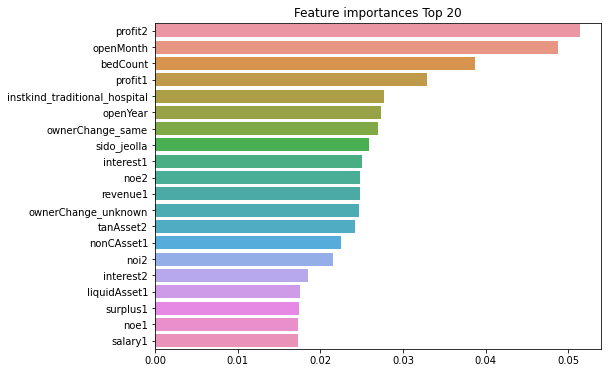

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
ftr_top20_rf = list(ftr_top20.index)
ftr_top20_rf

['profit2',
 'openMonth',
 'bedCount',
 'profit1',
 'instkind_traditional_hospital',
 'openYear',
 'ownerChange_same',
 'sido_jeolla',
 'interest1',
 'noe2',
 'revenue1',
 'ownerChange_unknown',
 'tanAsset2',
 'nonCAsset1',
 'noi2',
 'interest2',
 'liquidAsset1',
 'surplus1',
 'noe1',
 'salary1']

### Light GBM 

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(is_unbalance=True)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_valid, tgt_train=y_train, tgt_test=y_valid)

오차 행렬
[[ 0  5]
 [ 0 86]]
정확도: 0.9451, 정밀도: 0.9451, 재현율: 1.0000, F1: 0.9718, AUC:0.8814


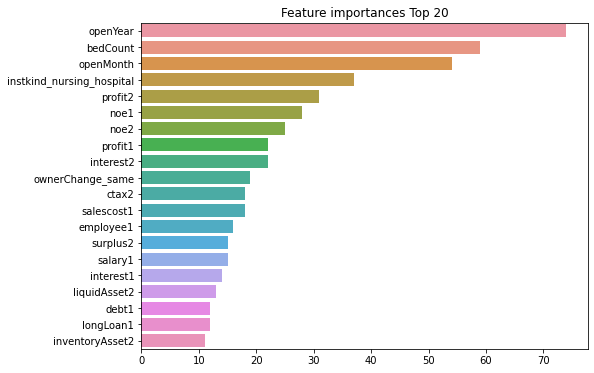

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lgbm_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
ftr_top20_lgbm = list(ftr_top20.index)
ftr_top20_lgbm

['openYear',
 'bedCount',
 'openMonth',
 'instkind_nursing_hospital',
 'profit2',
 'noe1',
 'noe2',
 'profit1',
 'interest2',
 'ownerChange_same',
 'ctax2',
 'salescost1',
 'employee1',
 'surplus2',
 'salary1',
 'interest1',
 'liquidAsset2',
 'debt1',
 'longLoan1',
 'inventoryAsset2']

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

xgb_clf = XGBClassifier()
get_model_train_eval(xgb_clf, ftr_train=X_train, ftr_test=X_valid, tgt_train=y_train, tgt_test=y_valid)

오차 행렬
[[ 0  5]
 [ 0 86]]
정확도: 0.9451, 정밀도: 0.9451, 재현율: 1.0000, F1: 0.9718, AUC:0.8465


In [ ]:
# 하이퍼 파라이터 튜닝
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[3, 5, 7], 
          'min_child_weight':[1,3, 5],
          'learning_rate':[0.05, 0.03, 0.01]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv = 3)
gridcv.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 
print('GridSearchCV 최고 예측 정확도: ', gridcv.best_score_)

xgb_roc_score = roc_auc_score(y_valid, gridcv.predict_proba(X_valid)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

GridSearchCV 최적 파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3}
GridSearchCV 최고 예측 정확도:  0.9523809523809524
ROC AUC: 0.8430


In [ ]:
xgb_clf_best = gridcv.best_estimator_

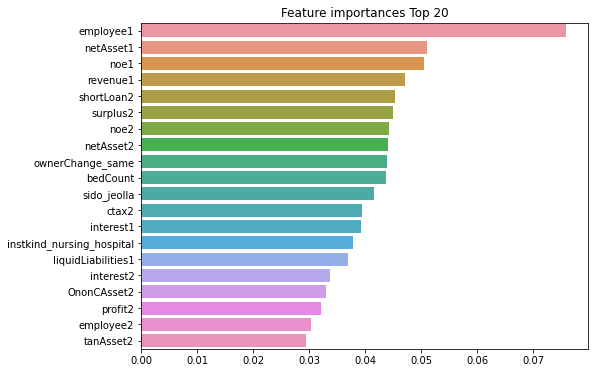

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_clf_best.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
ftr_top20_xgb = list(ftr_top20.index)

## feature selection

In [ ]:
ftr_selected = ftr_top20_rf + ftr_top20_lgbm + ftr_top20_xgb
ftr_selected = list(np.unique(ftr_selected)) # without duplicates
ftr_selected

['OnonCAsset2',
 'bedCount',
 'ctax2',
 'debt1',
 'employee1',
 'employee2',
 'instkind_nursing_hospital',
 'instkind_traditional_hospital',
 'interest1',
 'interest2',
 'inventoryAsset2',
 'liquidAsset1',
 'liquidAsset2',
 'liquidLiabilities1',
 'longLoan1',
 'netAsset1',
 'netAsset2',
 'noe1',
 'noe2',
 'noi2',
 'nonCAsset1',
 'openMonth',
 'openYear',
 'ownerChange_same',
 'ownerChange_unknown',
 'profit1',
 'profit2',
 'revenue1',
 'salary1',
 'salescost1',
 'shortLoan2',
 'sido_jeolla',
 'surplus1',
 'surplus2',
 'tanAsset2']

In [ ]:
X_train_small = X_train[ftr_selected]
X_valid_small = X_valid[ftr_selected]
X_test_small = X_valid[ftr_selected]

In [ ]:
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[3, 5, 7], 
          'min_child_weight':[1,3,5],
          'learning_rate':[0.05, 0.03, 0.01]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv = 3)
gridcv.fit(X_train_small, y_train)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 
print('GridSearchCV 최고 예측 정확도:', gridcv.best_score_)

GridSearchCV 최적 파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3}
GridSearchCV 최고 예측 정확도: 0.9523809523809524


## 스태킹 앙상블

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성
rf_clf = RandomForestClassifier(n_estimators=100)
lgbm_clf = LGBMClassifier(is_unbalance=True)
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_child_weight=3)

# 최종 Stacking 모델을 위한 Classifier 생성
lr_final = LogisticRegression(C=10)

In [ ]:
# 개별 모델들을 학습. 
rf_clf.fit(X_train_small, y_train)
lgbm_clf.fit(X_train_small , y_train)
xgb_clf.fit(X_train_small, y_train)

XGBClassifier(learning_rate=0.05, min_child_weight=3)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성
rf_pred = rf_clf.predict(X_valid_small)
lgbm_pred = lgbm_clf.predict(X_valid_small)
xgb_pred = xgb_clf.predict(X_valid_small)

# 개별 모델의 정확도 측정
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_valid, rf_pred)))
print('LGBM 트리 정확도: {0:.4f}'.format(accuracy_score(y_valid, lgbm_pred)))
print('XGBoost 정확도: {0:.4f} :'.format(accuracy_score(y_valid, xgb_pred)))

랜덤 포레스트 정확도: 0.9451
LGBM 트리 정확도: 0.9560
XGBoost 정확도: 0.9451 :


In [ ]:
pred = np.array([rf_pred, lgbm_pred, xgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. Column 레벨로 각 알고리즘의 예측 결과를 Feature로 만듦
pred = np.transpose(pred)
print(pred.shape)

(3, 91)
(91, 3)


In [ ]:
lr_final.fit(pred, y_valid)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_valid , final)))

최종 메타 모델의 예측 정확도: 0.9560


In [ ]:
# predict test set
rf_pred = rf_clf.predict(X_test_small)
lgbm_pred = lgbm_clf.predict(X_test_small)
xgb_pred = xgb_clf.predict(X_test_small)

In [ ]:
pred = np.array([rf_pred, lgbm_pred, xgb_pred])
pred = np.transpose(pred)
final = lr_final.predict(pred)

In [ ]:
final

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

- 망함..

## ensemble 다시

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100)
lgbm_clf = LGBMClassifier(is_unbalance=True)
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_child_weight=3)

# VotingClassifier 정의
from sklearn.ensemble import VotingClassifier
vo_clf = VotingClassifier(estimators=[('LGBM',lgbm_clf), ('XGB',xgb_clf), ('RF',rf_clf)], voting='soft')

In [ ]:
# fit 메소드를 이용해 모델 학습
vo_clf.fit(X_train_small,y_train)

VotingClassifier(estimators=[('LGBM', LGBMClassifier(is_unbalance=True)),
                             ('XGB',
                              XGBClassifier(learning_rate=0.05,
                                            min_child_weight=3)),
                             ('RF', RandomForestClassifier())],
                 voting='soft')

In [ ]:
vo_clf.predict(X_test_small) 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

- 망함

## | SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
___
- 결측치 채워야 돌아감..

In [ ]:
print(X_train.shape)

(301, 71)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (301, 71) (301,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (572, 71) (572,)
SMOTE 적용 후 레이블 값 분포: 
 1    286
0    286
Name: OC, dtype: int64


- 학습 데이터셋이 301건에서 572건으로 증식되었다.
- 레이블 값이 균일한 분포를 이루게 되었다.
- `X_train_over`, `y_train_over`

### Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_jobs = -1)
rf_clf.fit(X_train_small, y_train_over)
pred = rf_clf.predict(X_test_small) 

ValueError: ignored

- 오류 -> 결측치 유무 확인

In [ ]:
# nan값 하나라도 있는 행 출력
X_test[X_test.isna().any(axis=1)]

,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,...,sido_seoul,instkind_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,ownerChange_change,ownerChange_same,ownerChange_unknown
120,3.912023,20.140519,18.125425,20.122315,19.459845,14.959383,20.971152,17.325929,0.0,22.203031,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_test.iloc[120]

bedCount                          3.912023
revenue1                         20.140519
salescost1                       18.125425
sga1                             20.122315
salary1                          19.459845
                                   ...    
instkind_traditional_clinic       0.000000
instkind_traditional_hospital     0.000000
ownerChange_change                0.000000
ownerChange_same                  1.000000
ownerChange_unknown               0.000000
Name: 120, Length: 71, dtype: float64

In [ ]:
X_test.iloc[120] = X_test.iloc[120].fillna(0) # 0으로 채움

In [ ]:
rf_clf = RandomForestClassifier(n_jobs = -1)
rf_clf.fit(X_train_over, y_train_over)
pred_rf = rf_clf.predict(X_test)
pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

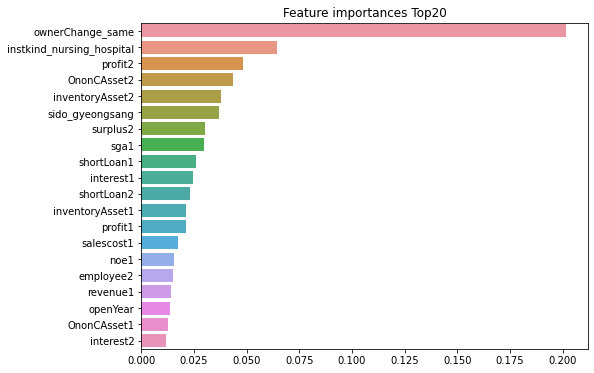

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
ftr_top20_rf = list(ftr_top20.index)

### Light GBM 

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(is_unbalance=False)
lgbm_clf.fit(X_train_over, y_train_over)
pred_lgbm = lgbm_clf.predict(X_test)
pred_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

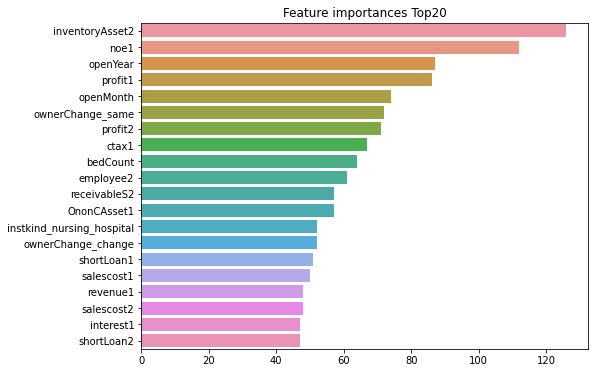

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lgbm_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
ftr_top20_lgbm = list(ftr_top20.index)

### XGBoost

In [ ]:
# 하이퍼 파라이터 튜닝
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier()

params = {'n_estimators':[70,80,90],
    'max_depth':[3, 5, 7], 
          'min_child_weight':[1,3, 5],
          'learning_rate':[0.05, 0.03, 0.01]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv = 3, n_jobs = -1)
gridcv.fit(X_train_over, y_train_over)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 
print('GridSearchCV 최고 예측 정확도: ', gridcv.best_score_)

GridSearchCV 최적 파라미터: {'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 70}
GridSearchCV 최고 예측 정확도:  0.9404978414622945


In [403]:
xgb_best = grid_cv.best_estimator_
xgb_best.fit(X_train_over, y_train_over)
xgb_pred = xgb_best.predict(X_test)
pred_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]

sub['OC']=xgb_pred
sub[sub.OC==0]['inst_id']

ValueError: ignored

In [ ]:
# csv 파일로 저장합니다.
sub.to_csv('/content/drive/MyDrive/esaa_data/9565_hospital_data/submission.csv', index=False)

- public score: 0.873015873
- lgbm, rf 중 리더보드 점수가 높음

In [ ]:
xgb_clf_best = gridcv.best_estimator_

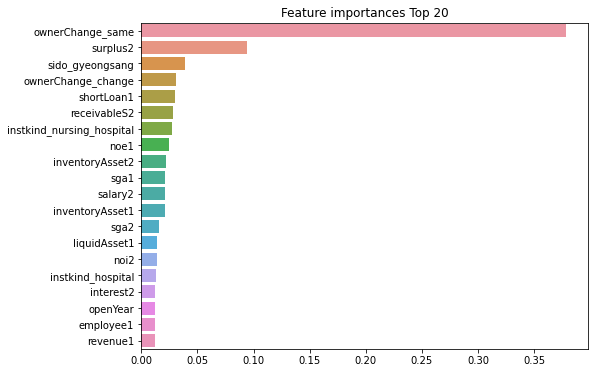

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_clf_best.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train_over.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## ensemble 

In [ ]:
ensemble = pd.DataFrame()
ensemble['inst_id'] = sub['inst_id']
ensemble['XGB'] = pred_proba_xgb
ensemble['LGBM'] = pred_proba_lgbm
ensemble['RF'] = pred_proba_rf

# Taking the average of all 3 models
ensemble['ens'] = (ensemble['XGB'] + ensemble['LGBM'] + ensemble['RF'])/3

ensemble

,inst_id,XGB,LGBM,RF,ens
0,2,0.990679,0.999674,0.99,0.993451
1,5,0.978112,0.999449,0.95,0.975854
2,6,0.981858,0.998684,0.94,0.973514
3,8,0.878482,0.999486,0.86,0.912656
4,10,0.997137,0.999896,0.96,0.985678
...,...,...,...,...,...
122,424,0.187748,0.634978,0.51,0.444242
123,425,0.997524,0.999634,0.91,0.969053
124,429,0.323324,0.852989,0.76,0.645438
125,430,0.989930,0.999480,0.96,0.983137


In [ ]:
threshold = 0.7
final_pred = []
for i in ensemble['ens']:
  if i > threshold:
    final_pred.append(1)
  else:
    final_pred.append(0)

sub['OC'] = final_pred
sub[sub.OC==0]['inst_id']

52     165
83     254
88     293
122    424
124    429
126    431
Name: inst_id, dtype: int64

In [ ]:
threshold = 0.8
final_pred = []
for i in ensemble['ens']:
  if i > threshold:
    final_pred.append(1)
  else:
    final_pred.append(0)

sub['OC'] = final_pred
sub[sub.OC==0]['inst_id']

23      66
52     165
83     254
88     293
120    413
122    424
124    429
126    431
Name: inst_id, dtype: int64

In [ ]:
threshold = 0.85
final_pred = []
for i in ensemble['ens']:
  if i > threshold:
    final_pred.append(1)
  else:
    final_pred.append(0)

sub['OC'] = final_pred
print(sub[sub.OC==0]['inst_id'])
sub.to_csv('/content/drive/MyDrive/esaa_data/9565_hospital_data/submission.csv', index=False)

20      48
23      66
52     165
67     210
83     254
88     293
120    413
122    424
124    429
126    431
Name: inst_id, dtype: int64


- public score: 0.8571428571
- XGBoost보다 더 내려감...

In [ ]:
threshold = 0.
final_pred = []
for i in ensemble['ens']:
  if i > threshold:
    final_pred.append(1)
  else:
    final_pred.append(0)

sub['OC'] = final_pred
sub[sub.OC==0]['inst_id']

In [ ]:
sub.to_csv('/content/drive/MyDrive/esaa_data/9565_hospital_data/submission.csv', index=False)

- ensemble 결과가 XGBoost 보다 안좋게 나옴

## 다다시 XGBoost
- XGboost는 결측치를 알아서 돌리기 때문에 결측치를 평균으로 대체하지 않고 모델을 돌려봄
- 연속형 중 음수값이 있는 변수는 standardization
- 연속 형 중 음수값이 없는 변수는 log transformation

In [2]:
# 종종종합 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# 전처리 종종합 코드
test = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/test.csv")
train = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/train.csv")
sub = pd.read_csv("/content/drive/MyDrive/esaa_data/9565_hospital_data/submission_sample.csv")

train['OC'].replace({'open':1, ' close':0}, inplace=True)

train.drop('sgg', axis=1, inplace=True)
test.drop('sgg', axis=1, inplace=True)

train.drop('inst_id', axis=1, inplace=True) #'inst_id' 열 제거
test.drop('inst_id', axis=1, inplace=True)

train['sido'] = train['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})
test['sido'] = test['sido'].replace({'choongnam':'choongcheong','choongbuk':'choongcheong', 'daejeon':'choongcheong', 'sejong':'choongcheong', 
                                       'jeonnam':'jeolla','jeonbuk':'jeolla', 'gwangju':'jeolla',
                                       'gyeongnam':'gyeongsang','gyeongbuk':'gyeongsang', 'ulsan':'gyeongsang', 'daegu':'gyeongsang',
                                       'incheon':'gyeonin', 'gyeonggi':'gyeonin'})

train['openDate'] = train['openDate'].astype(str)
test['openDate'] = test['openDate'].fillna(0).astype(int) # test 결측치 0으로 치환
test['openDate'] = test['openDate'].astype(str)
train['openDate'] = pd.to_datetime(train['openDate'])
test['openDate'] = pd.to_datetime(test['openDate'], errors='coerce')
train["openYear"] = train["openDate"].dt.year
train["openMonth"] = train["openDate"].dt.month
test["openYear"] = test["openDate"].dt.year
test["openMonth"] = test["openDate"].dt.month
train.drop(columns="openDate", axis=1, inplace=True)
test.drop(columns="openDate", axis=1, inplace=True)

train['ownerChange'] = train['ownerChange'].fillna('unknown')
test['ownerChange'] = test['ownerChange'].fillna('unknown')

train['instkind'] = train['instkind'].replace('dental_clinic','clinic')

test["employee1"] = test["employee1"].str.replace(",","").astype("float")
test["employee2"] = test["employee2"].str.replace(",","").astype("float")

train_one =pd.get_dummies(data=train)
test_one =pd.get_dummies(data=test)

cont = train_one.iloc[:,1:52]
neg_col = []
for col in cont.columns:
  for i in cont[col]:
    if i < 0:
      neg_col.append(col)
      break
non_neg_col = list(cont.columns)
for i in neg_col:
  non_neg_col.remove(i)

train_one[non_neg_col] = np.log1p(train_one[non_neg_col])
# for col in neg_col:
#   train_one[col] = np.log1p(train_one[col]-train_one[col].min())
test_one[non_neg_col] = np.log1p(test_one[non_neg_col])
# for col in neg_col:
#   test_one[col] = np.log1p(test_one[col]-test_one[col].min())

from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(train_one[non_neg_col])
train_one[non_neg_col] = standard_scaler.transform(train_one[non_neg_col])
standard_scaler.fit(test_one[non_neg_col])
test_one[non_neg_col] = standard_scaler.transform(test_one[non_neg_col])

X_train = train_one.drop('OC', axis=1)
y_train = train_one['OC']
X_test = test_one.drop('OC', axis=1)

X_test = X_test.drop("sido_jeju", axis=1)
X_train = X_train.drop("sido_gangwon", axis=1)


In [499]:
# 하이퍼 파라이터 튜닝
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier()

params = {'n_estimators':[50,60,70,80,90],
    'max_depth':[3, 5, 7], 
          'min_child_weight':[1,3, 5],
          'learning_rate':[0.05, 0.03, 0.01]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv = 3, n_jobs = -1)
gridcv.fit(X_train_over, y_train_over)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 
print('GridSearchCV 최고 예측 정확도: ', gridcv.best_score_)


KeyboardInterrupt: ignored

In [520]:
# 하이퍼 파라이터 튜닝
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier()

params = {'n_estimators':[70,80,90],
    'max_depth':[3, 5, 7], 
          'min_child_weight':[1,3, 5],
          'learning_rate':[0.05, 0.03, 0.01]
          }

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv = 3, n_jobs = -1)
gridcv.fit(X_train_over, y_train_over)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_) 
print('GridSearchCV 최고 예측 정확도: ', gridcv.best_score_)


GridSearchCV 최적 파라미터: {'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 70}
GridSearchCV 최고 예측 정확도:  0.9404978414622945


In [454]:
X_test = X_test.drop("sido_jeju", axis=1)

In [455]:
X_train = X_train.drop("sido_gangwon", axis=1)

In [519]:
xgb_clf_best = gridcv.best_estimator_
xgb_clf_best.fit(X_train, y_train)
xgb_pred = xgb_clf_best.predict(X_test)

sub['OC']=xgb_pred
sub[sub.OC==0]['inst_id']

10      24
13      30
22      64
40     123
78     229
83     254
84     258
88     293
99     341
122    424
123    425
124    429
125    430
126    431
Name: inst_id, dtype: int64

In [6]:
lgbm = LGBMClassifier(n_estimator = 500, is_balance=True)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
sub['OC'] = pred
sub[sub.OC==0]['inst_id']

52     165
83     254
84     258
124    429
126    431
Name: inst_id, dtype: int64

In [421]:
sub.to_csv('/content/drive/MyDrive/esaa_data/9565_hospital_data/submission.csv', index=False)

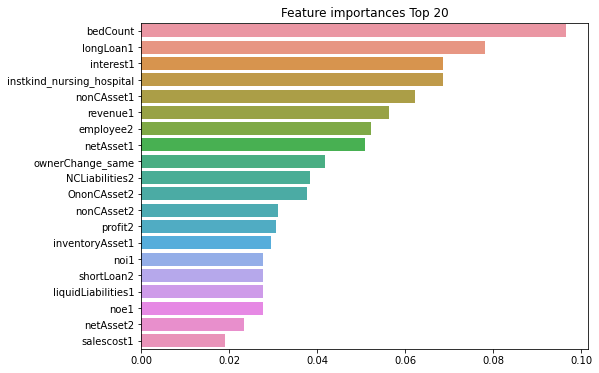

In [413]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_clf_best.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train_over.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

# 최종 XGboost 모델링
- imbalanced data tuning하는 scale_pos_weight 적용

In [ ]:
X4_train, X4_valid, y4_train, y4_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
xgb_model2 = XGBClassifier(n_estimators=500)

params = {'max_depth':[4,6,8,10],
          'min_child_weight':[0.5,1,1.5],
          'subsample':[0.6, 0.8, 1],
          'gamma':[0,0.05,0.1,0.15,0.2],
          'scale_pos_weight':[4,19]}

gridcv2 = GridSearchCV(xgb_model2, param_grid=params, cv=3)

gridcv2.fit(X4_train, y4_train, early_stopping_rounds=30, eval_metric="error",
           eval_set=[(X4_train, y4_train), (X4_valid, y4_valid)])

Streaming output truncated to the last 5000 lines.
[26]	validation_0-error:0.029915	validation_1-error:0.033898
[27]	validation_0-error:0.029915	validation_1-error:0.033898
[28]	validation_0-error:0.029915	validation_1-error:0.033898
[29]	validation_0-error:0.034188	validation_1-error:0.033898
[30]	validation_0-error:0.029915	validation_1-error:0.033898
[31]	validation_0-error:0.034188	validation_1-error:0.033898
Stopping. Best iteration:
[1]	validation_0-error:0.047009	validation_1-error:0.033898

[0]	validation_0-error:0.038462	validation_1-error:0.067797
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.034188	validation_1-error:0.067797
[2]	validation_0-error:0.034188	validation_1-error:0.067797
[3]	validation_0-error:0.029915	validation_1-error:0.067797
[4]	validation_0-error:0.029915	validation_1-error:0.067797
[5]	validation_0-error:0.029915	val

KeyboardInterrupt: ignored

In [ ]:
xgb_model2 = XGBClassifier(n_estimators=500)

params = {'max_depth':[4,6,8,10],
          'min_child_weight':[0.5,1,1.5],
          'subsample':[0.6, 0.8, 1],
          'gamma':[0,0.05,0.1,0.15,0.2],
          'scale_pos_weight':[4,19]}

gridcv2 = GridSearchCV(xgb_model2, param_grid=params, cv=3)

gridcv2.fit(X4_train, y4_train, early_stopping_rounds=30, eval_metric="error",
           eval_set=[(X4_train, y4_train), (X4_valid, y4_valid)])

Streaming output truncated to the last 5000 lines.
[26]	validation_0-error:0.029915	validation_1-error:0.033898
[27]	validation_0-error:0.029915	validation_1-error:0.033898
[28]	validation_0-error:0.029915	validation_1-error:0.033898
[29]	validation_0-error:0.034188	validation_1-error:0.033898
[30]	validation_0-error:0.029915	validation_1-error:0.033898
[31]	validation_0-error:0.034188	validation_1-error:0.033898
Stopping. Best iteration:
[1]	validation_0-error:0.047009	validation_1-error:0.033898

[0]	validation_0-error:0.038462	validation_1-error:0.067797
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.034188	validation_1-error:0.067797
[2]	validation_0-error:0.034188	validation_1-error:0.067797
[3]	validation_0-error:0.029915	validation_1-error:0.067797
[4]	validation_0-error:0.029915	validation_1-error:0.067797
[5]	validation_0-error:0.029915	val

KeyboardInterrupt: ignored

In [ ]:
xgb = XGBClassifier(gamma = 0.15, max_depth = 4, min_child_weight = 0.5, subsample = 0.6, scale_pos_weight = 19)

evals = [(X4_valid, y4_valid)]
xgb.fit(X4_train, y4_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals,
                verbose=True)

xgb_acc_score4 = accuracy_score(y4_valid, xgb.predict(X4_valid))
print('accuacy: {0:.4f}'.format(xgb_acc_score4))

[0]	validation_0-error:0.033898
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.033898
[2]	validation_0-error:0.033898
[3]	validation_0-error:0.033898
[4]	validation_0-error:0.033898
[5]	validation_0-error:0.033898
[6]	validation_0-error:0.033898
[7]	validation_0-error:0.033898
[8]	validation_0-error:0.033898
[9]	validation_0-error:0.033898
[10]	validation_0-error:0.033898
[11]	validation_0-error:0.033898
[12]	validation_0-error:0.033898
[13]	validation_0-error:0.033898
[14]	validation_0-error:0.033898
[15]	validation_0-error:0.033898
[16]	validation_0-error:0.033898
[17]	validation_0-error:0.033898
[18]	validation_0-error:0.033898
[19]	validation_0-error:0.033898
[20]	validation_0-error:0.033898
[21]	validation_0-error:0.033898
[22]	validation_0-error:0.033898
[23]	validation_0-error:0.033898
[24]	validation_0-error:0.033898
[25]	validation_0-error:0.033898
[26]	validation_0-error:0.033898
[27]	validation_0-error:0.033898
[28]	validation_0-e

In [ ]:
print('GridSearchCV 최적 파라미터:', gridcv2.best_params_)

GridSearchCV 최적 파라미터: {'gamma': 0.15, 'max_depth': 4, 'min_child_weight': 0.5, 'subsample': 0.6}


In [ ]:
xgb = XGBClassifier(gamma = 0.15, max_depth = 4, min_child_weight = 0.5, subsample = 0.6, scale_pos_weight=19)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
sub['OC'] = xgb_pred
sub[sub.OC==0]['inst_id']

10      24
13      30
22      64
40     123
78     229
83     254
84     258
88     293
99     341
122    424
123    425
124    429
125    430
126    431
Name: inst_id, dtype: int64

In [ ]:
sub.to_csv('/content/drive/MyDrive/esaa_data/9565_hospital_data/submission.csv', index=False)

- public score: 0.9523809524